### Challenge Title: Predicting Relative Returns in assets Deadline Dec 6 2024 midnight UTC

#### Objective
Participants are challenged to develop a predictive signal that forecasts the relative returns of a set of assets. The goal is to create a signal $P(i)$ at each timestamp $i$ that effectively predicts the next period’s excess returns for multiple assets compared to a market index. The objective is to maximize a utility function $U$, which measures both the predictive accuracy and consistency of the signal in forecasting these relative returns.

#### Background
Financial markets are known for their nonstationarity and complex dynamics. The assets here, which will remain masked,  enable leveraged trading without an expiry date, are particularly popular and offer unique opportunities for relative return prediction. This challenge tests participants’ ability to forecast returns that are not only accurate but also consistent over time.

#### Data Description
- **Input Data:** A time series of returns from assets, $X(i) = (X_1(i), X_2(i), ..., X_J(i))$, where $i$ denotes the time index expressed as an integer, and each $X_j(i)$ represents the return of the $j$-th asset at time $i$.
- **Prediction Target:** At each time $i$, participants will predict a vector signal $P(i) = (P_1(i), P_2(i), ..., P_J(i))$, where each $P_j(i)$ represents the participant’s prediction for the relative return of the $j$-th asset in the next time step, $i+1$, compared to the index.

   > **Note:** The actual values of the target relative returns, $R(i+1)$, are obfuscated to maintain data confidentiality, and participants will work with pre-processed, relative return values that do not reveal underlying raw prices.

- **Feature Data:** In addition to historical return data, participants will have access to a set of obfuscated features. Each timestamp $i$ is associated with a feature vector $F(i) = (F_1(i), F_2(i), ..., F_K(i))$, where $K$ is the number of available features, and each feature is identified only by its index (e.g., $F_1, F_2, \dots, F_K$).

#### Objective Function (Utility)
The performance of each submission will be evaluated using the following utility function:

$$
U = \frac{\mathbb{E}[P(i) \cdot R(i+1)]}{\operatorname{std}(P(i) \cdot R(i+1))}
$$

where:
- $ R(i+1) $ represents the vector of relative returns of each asset versus the index at time $i+1$.
- The term $P(i) \cdot R(i+1)$ captures the alignment between the prediction $P(i)$ and the realized relative return $R(i+1)$.
- The numerator, $\mathbb{E}[P(i) \cdot R(i+1)]$, represents the average predictive alignment.
- The denominator, $\operatorname{std}(P(i) \cdot R(i+1))$, promotes stability by penalizing high variance.

#### Scoring Criteria

For now we will ignore overfitting tests, but in the future, when we are up an running with material capital, overfit signals will be flagged and disqualified. You may read about overfitting in the literature. For example, "The Deflated Sharpe Ratio: Correcting for Selection Bias, Backtest Overfitting and Non-Normality" by De Prado and Bailey. We encourage you to do your own overfitting tests. the return values of the Optimization in the example below would allow one to easily use some of the methods in the aforementioned paper.

Participants submissions be ranked based on their utility $U$, which can be interpreted as a non-scaled Sharpe Ratio, assuming zero transaction costs. This scoring assumes:
- **Nominal position sizes** in each asset are determined directly by the predictions $P(i)$.
- An **offsetting hedge** is taken in an index, with size equal to the sum of predictions at each timestamp, resulting in a market-neutral strategy.

1. **Accuracy**: High values of $P(i) \cdot R(i+1)$ indicate strong predictive alignment with the relative returns.
2. **Consistency**: Lower standard deviation of $P(i) \cdot R(i+1)$ rewards predictions that maintain stability over time, resulting in a more robust $U$.

#### Submission Format
The submission should be a copy of this notebook, or a .py file with same content as this template, except for your specific predictor. PLEASE NAME YOUR NOTEBOOK IN THE FORM "AlphaNovaContestTemplate.<your email address>" WITH EITHER THE RESPECTIVE NOTEBOOK OR .PY SUFFIX. Follow the example below and create your own Predictor class in place of the example class that is defined. Your work will involve a) creating parameters, b) optimizing and c) prediction logic, all clearly defined in the methods of the base class.   You do *not* have to follow the example's optimization approach, which is rudimentary brute force search over a defined grid of parameters. Submit your work to competitions@alphanova.tech

The output of your prediction, as per the example below should be a dataframe with the following information:  For each time $i$, participants must submit a vector $P(i) = (P_1(i), P_2(i), ..., P_J(i))$ that represents their forecast for the next time step’s relative returns across all assets in the dataset.

#### Guidelines
- **Direct Signal Usage**: To ensure simplicity and transparency, participants should submit $P(i) = K(i)$, meaning no additional scaling factors (such as $\beta$) are applied to the predictions.  
- **Robustness Across Market Conditions**: Given the high volatility and nonstationarity of markets, signals that perform well across diverse market regimes are encouraged.

#### Winning Criteria
The participant with the highest utility $U$ over the Test Set will be declared the winner. In the event that multiple users by chance have the same winning utility, we will reward the full prize to the contestant who submitted his/her solution *first*.

#### Test Set
The evaluation will be conducted over a hidden test set, that he hold but you do not have, during which $ U $ will be calculated based on the predictions submitted by participants.  

#### Additional Notes
- **Data Confidentiality**: Both target returns and feature data are obfuscated. Features are labeled only by an index, and timestamps are represented as sequential integers.
- **Scoring Interpretation**: The utility function $ U $ is designed as a **non-scaled Sharpe Ratio** assuming a zero-cost, market-neutral strategy, where nominal positions are determined by the predictions $P(i)$ with an offsetting index hedge equal to the sum of predictions.

#### Submission Deadline
This will be detailed in the email in which this was attached.

#### Important Note for the avoidance of doubt
The only things you need to change in your version of this notebook are a) possible additional imports of modules and b) replace the example Prediction class with its own parameters, optimize and predict methods.  Don't edit anything else

#### We have provided a requirements.txt, which is very short, but this is due to feedback on pandas/numpy incompatibility.  

# Example of prediction

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from itertools import product



## read in data

In [5]:
returns=pd.read_pickle("returns.06.12.24.pkl")
target=pd.read_pickle("rel_returns.06.12.24.pkl")
features=pd.read_pickle("features.06.12.24.pkl")

# split into train and validate.  please use test_size=0.25 as indicated below

In [6]:
train_target, validate_target = train_test_split(target, test_size=0.25,shuffle=False )
train_returns, validate_returns = train_test_split(returns, test_size=0.25,shuffle=False)
train_features, validate_features = train_test_split(features, test_size=0.25,shuffle=False )

train_data={'returns':train_returns,'features':train_features}

validate_data={'returns':validate_returns,'features':validate_features}

## helper functions

In [7]:
def backtest(predictions,relative_returns):
    predictions.ffill(inplace=True)
    #the following is closely relatived to measuring the lead lag correlation of the prediction to the outcome.
    pf_returns = (predictions.shift(1)).mul(relative_returns.values).sum(axis=1)
    pf_returns.iloc[0] = 0  # first day return is 0, because we do not have prediction for time i=-1
    return pf_returns

def returns_to_equity(returns):
    equity = returns.add(1).cumprod()
    return equity

def utility_sharpe(returns):
    unscaled_sharpe=returns.mean()/returns.std()
    return float(unscaled_sharpe)

In [8]:
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import math

def ClassByName(classname):
    cls = globals()[classname]

    return cls()

def PredictorFactory(config):
    ind=ClassByName(config['type'])
    ind.set_parms(**config['parms'])
    return ind

class Predictor(ABC):

    @abstractmethod
    def set_parms(self, **parms):
        pass

    @abstractmethod
    #train model to find best parameters, whether explicit or implicit to maximize utility
    def train(self, data,target):
        pass

    @abstractmethod
    def predict(self,data):
        pass


class RollingAverageReturn(Predictor):

    def __init__(self,window=1,direction=1):
        self._window=window
        self._direction=direction

    def set_parms(self, **parms):
        self._window = parms['window']
        self._direction=parms['direction']

    def train(self,data,target):
        param_space = {
            "window": range(1,500),
            "direction":[-1,1]
        }
        best_utility=-100
        best_parms=None
        df_strategy_returns=pd.DataFrame()
        c=0
        for values in product(*param_space.values()):
            parms = {key: val for key, val in zip(param_space.keys(), values)}
            self.set_parms(**parms)
            predictions = self.predict(data)
            strategy_returns = backtest(predictions,target)

            utility=utility_sharpe(strategy_returns)
     
            
       
            if utility>best_utility:
                best_parms=parms
                best_utility=utility
            df_strategy_returns[str(parms)]=strategy_returns

        self.set_parms(**best_parms)

        return df_strategy_returns,best_parms,float(best_utility)
            
                


    def predict(self,data):
  
        returns=(data['returns'])

        #smooths the sign of returns 
        pred = self._direction*returns.rolling(window=self._window).mean()

        #normalizes so sum of absolute valuies of predictons is 1
        pred=pred.divide(abs(pred).sum(axis=1),axis=0)
        return pred

# train

In [9]:
predictor=RollingAverageReturn()
df_strategy_returns,best_parms,best_utility=predictor.train(train_data,train_target)

/var/folders/bw/4y4dqjhj0ylcvj9lkw3g7bdr0000gn/T/ipykernel_21116/4017750486.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_strategy_returns[str(parms)]=strategy_returns
/var/folders/bw/4y4dqjhj0ylcvj9lkw3g7bdr0000gn/T/ipykernel_21116/4017750486.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_strategy_returns[str(parms)]=strategy_returns
/var/folders/bw/4y4dqjhj0ylcvj9lkw3g7bdr0000gn/T/ipykernel_21116/4017750486.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [10]:
best_parms

{'window': 1, 'direction': -1}

In [11]:
best_utility

0.02992129026464651

### train backtest

<Axes: >

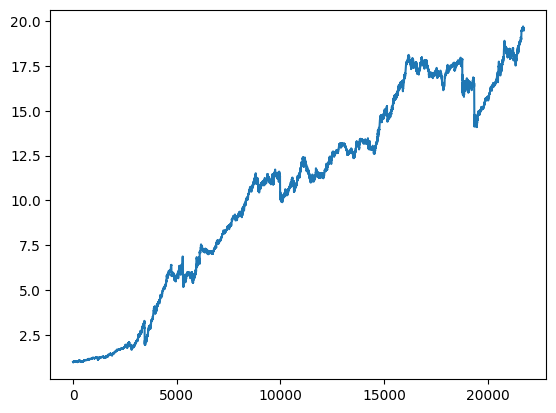

In [12]:
returns_to_equity(df_strategy_returns[str(best_parms)]).plot()

# VALIDATE

In [13]:
predictor_best=RollingAverageReturn(**best_parms)

In [14]:
predictions=predictor_best.predict(validate_data)

In [15]:
pnl=backtest(predictions,validate_target)

In [16]:
utility=utility_sharpe(pnl)

In [17]:
utility

0.04086585640913292

## validation backtest

<Axes: >

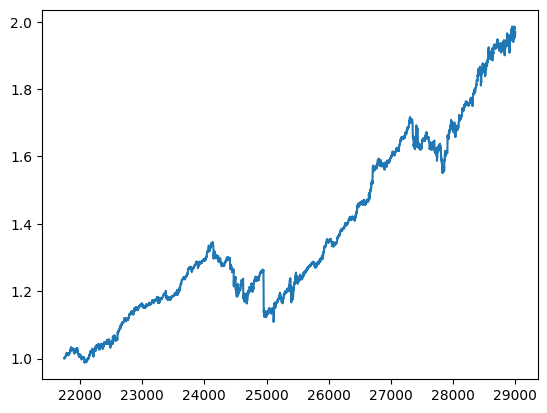

In [19]:
returns_to_equity(pnl).plot()